In [1]:
from soxs.utils import soxs_cfg
soxs_cfg.set('soxs', 'bkgnd_nH', '0.018')
import soxs

soxs : [WARNING  ] 2024-05-22 12:27:16,826 Setting 'soxs_data_dir' to /u/madepa/.cache/soxs for this session. Please update your configuration if you want it somewhere else.


In [2]:
import yt
import pyxsim

import h5py
import numpy as np
import illustris_python as il

import os
from regions import RectangleSkyRegion
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy import wcs
from astropy.io import fits

In [30]:
basePath = '/virgotng/universe/IllustrisTNG/TNG100-1/output'
snap = 99
haloID = 14 


def Xray_mock(basePath, snap, haloID, exp_time, emin, emax, area, box_size, instrument, instrument_exp, sky_center_offset=0):
    '''
    generates an X-ray mock for a halo
    input: basePath, snapshot, haloID, exp_time in ks, 
           emin, emax as values in keV, area in cm**2, 
           box_size of the simulated source in Mpc,
           instrument name from pyxsim as string,
           sky_center_offset for the instrument sky center to be shifted (in arc mins)
    '''
    # loading the halo, particle, header data
    halo = il.groupcat.loadSingle(basePath, snap, haloID=haloID)
    gas = il.snapshot.loadHalo(basePath, snap, haloID, 'gas')
    header = il.groupcat.loadHeader(basePath, snap)

    # loading the mass table
    with h5py.File(il.snapshot.snapPath(basePath, snap),'r') as f:
        header_snap = dict(f['Header'].attrs)

    # writing an HDF5 file to store the loaded data for yt use
    filename = "../data/mockhalo_%d.hdf5" % haloID
    with h5py.File(filename,'w') as f:
        for key in gas.keys():
            f['PartType0/' + key] = gas[key]

        # some metadata that yt demands
        f.create_group('Header')
        f['Header'].attrs['NumFilesPerSnapshot'] = 1
        f['Header'].attrs['MassTable'] = header_snap['MassTable']
        f['Header'].attrs['BoxSize'] = header['BoxSize']
        f['Header'].attrs['Time'] = header['Time']
        f['Header'].attrs['NumPart_ThisFile'] = np.array([gas['count'],0,0,0,0,0])

        # Must have the next six for correct units
        f["Header"].attrs["HubbleParam"] = header["HubbleParam"]
        f["Header"].attrs["Omega0"] = header["Omega0"]
        f["Header"].attrs["OmegaLambda"] = header["OmegaLambda"]

        # These correspond to the values from the TNG simulations
        f["Header"].attrs["UnitLength_in_cm"] = header_snap['UnitLength_in_cm']
        f["Header"].attrs["UnitMass_in_g"] = header_snap['UnitMass_in_g']
        f["Header"].attrs["UnitVelocity_in_cm_per_s"] = header_snap['UnitVelocity_in_cm_per_s']

    # load yt dataset
    ds = yt.load(filename)

    # define and add a hotgas filter to the dataset
    def hot_gas(pfilter, data):
        pfilter1 = data[pfilter.filtered_type, "temperature"] > 3.0e5
        pfilter2 = data["PartType0", "StarFormationRate"] == 0.0
        pfilter3 = data["PartType0", "GFM_CoolingRate"] < 0.0
        return (pfilter1 & pfilter2) & pfilter3

    yt.add_particle_filter("hot_gas", function=hot_gas,
                           filtered_type='gas', requires=["temperature","density"])

    ds.add_particle_filter("hot_gas")
    
    # set the center for the simulated box
    c = ds.arr([halo["GroupPos"][0], halo["GroupPos"][1], halo["GroupPos"][2]], "code_length")

    # defining the source redshift and the size of the simulated box
    redshift = 0.025
    width = ds.quan(box_size, "Mpc")
    le = c - 0.5*width
    re = c + 0.5*width
    box = ds.box(le, re)
    
    # set the source model to simulate the source
    nbins = 4000       
    source_model = pyxsim.CIESourceModel("apec", emin, emax, nbins, ("hot_gas","metallicity"),
                                         temperature_field=("hot_gas","temperature"),
                                         emission_measure_field=("hot_gas", "emission_measure"))
    
    # generating and projecting the photon events using pyxsim and writing to simput
    n_photons, n_cells = pyxsim.make_photons(f"halo_{haloID}_photons", box, redshift, (area, 'cm**2'), (exp_time, 'ks'), source_model)

    n_events = pyxsim.project_photons(f"halo_{haloID}_photons", f"halo_{haloID}_events", "z", (45.,30.),
                                      absorb_model="wabs", nH=0.01)

    events = pyxsim.EventList(f"halo_{haloID}_events.h5")
    events.write_to_simput(f"halo_{haloID}", overwrite=True)

    #simulating the observation based on the instrument and plotting
    soxs.instrument_simulator(f"halo_{haloID}_simput.fits", f"halo_{haloID}_evt.fits", (instrument_exp, 'ks'), instrument, (45. + (sky_center_offset/60), 30 - (sky_center_offset/60)), 
                              overwrite=True, foreground=False, ptsrc_bkgnd=False)



In [6]:
Xray_mock(basePath, snap, haloID, 100, 0.05, 4.0, 5000, 0.3, 'lem_outer_array', 50)

yt : [INFO     ] 2024-05-16 14:41:40,588 Redshift is not set in Header. Assuming z=0.
yt : [INFO     ] 2024-05-16 14:41:40,603 Calculating time from 1.000e+00 to be 4.356e+17 seconds
yt : [INFO     ] 2024-05-16 14:41:40,707 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2024-05-16 14:41:40,707 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2024-05-16 14:41:40,708 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2024-05-16 14:41:40,708 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2024-05-16 14:41:40,709 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-05-16 14:41:40,709 Parameters: current_redshift          = 0.0
yt : [INFO     ] 2024-05-16 14:41:40,710 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2024-05-16 14:41:40,710 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2024-05-16 14:41:40,710 Parameters: omega_radiation           =

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

Processing cells/particles :   0%|          | 0/60853 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2024-05-16 14:42:50,109 Finished generating photons.
pyxsim : [INFO     ] 2024-05-16 14:42:50,110 Number of photons generated: 352165
pyxsim : [INFO     ] 2024-05-16 14:42:50,111 Number of cells with photons: 40956
pyxsim : [INFO     ] 2024-05-16 14:42:50,114 Foreground galactic absorption: using the wabs model and nH = 0.01.


Projecting photons from cells/particles :   0%|          | 0/40956 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2024-05-16 14:42:50,185 Detected 35456 events.
soxs : [INFO     ] 2024-05-16 14:42:50,282 Writing source 'halo_141' to halo_141_phlist.fits.


In [31]:
Xray_mock(basePath, snap, haloID, 800, 0.05, 4.0, 5000, 0.3, 'chandra_acisi_cy0', 600, sky_center_offset=4/60)

yt : [INFO     ] 2024-05-17 08:57:27,999 Redshift is not set in Header. Assuming z=0.
yt : [INFO     ] 2024-05-17 08:57:28,009 Calculating time from 1.000e+00 to be 4.356e+17 seconds
yt : [INFO     ] 2024-05-17 08:57:28,096 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2024-05-17 08:57:28,097 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2024-05-17 08:57:28,097 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2024-05-17 08:57:28,098 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2024-05-17 08:57:28,099 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-05-17 08:57:28,099 Parameters: current_redshift          = 0.0
yt : [INFO     ] 2024-05-17 08:57:28,100 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2024-05-17 08:57:28,101 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2024-05-17 08:57:28,101 Parameters: omega_radiation           =

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

Processing cells/particles :   0%|          | 0/1043092 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2024-05-17 09:00:41,059 Finished generating photons.
pyxsim : [INFO     ] 2024-05-17 09:00:41,061 Number of photons generated: 167847524
pyxsim : [INFO     ] 2024-05-17 09:00:41,061 Number of cells with photons: 1043092
pyxsim : [INFO     ] 2024-05-17 09:00:41,064 Foreground galactic absorption: using the wabs model and nH = 0.01.


Projecting photons from cells/particles :   0%|          | 0/1043092 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2024-05-17 09:01:13,145 Detected 59309928 events.
soxs : [WARNING  ] 2024-05-17 09:01:14,948 Overwriting halo_14_phlist.fits.
soxs : [INFO     ] 2024-05-17 09:01:15,769 Writing source 'halo_14' to halo_14_phlist.fits.
soxs : [INFO     ] 2024-05-17 09:01:17,998 Making observation of source in halo_14_evt.fits.
soxs : [INFO     ] 2024-05-17 09:01:21,802 Detecting events from source halo_14.
soxs : [INFO     ] 2024-05-17 09:01:21,804 Applying energy-dependent effective area from acisi_aimpt_cy0.arf.
soxs : [INFO     ] 2024-05-17 09:01:25,228 Pixeling events.
soxs : [INFO     ] 2024-05-17 09:01:25,583 Scattering events with a multi_image-based PSF.
soxs : [INFO     ] 2024-05-17 09:01:26,086 1352338 events were detected from the source.
soxs : [INFO     ] 2024-05-17 09:01:26,172 Scattering energies with RMF acisi_aimpt_cy0.rmf.


Scattering energies :   0%|          | 0/1352338 [00:00<?, ?it/s]

soxs : [INFO     ] 2024-05-17 09:01:26,885 Adding background events.
soxs : [INFO     ] 2024-05-17 09:01:26,937 Adding in instrumental background.
soxs : [INFO     ] 2024-05-17 09:01:27,004 Making 682148 events from the instrumental background.
soxs : [INFO     ] 2024-05-17 09:01:27,042 Writing events to file halo_14_evt.fits.
soxs : [INFO     ] 2024-05-17 09:01:27,533 Observation complete.


## Halo trial


In [3]:
haloID = 22
events = pyxsim.EventList('../mockdata/SIMBA/%s'%f"halo_{haloID}_events.h5")
events.write_to_simput(f"halo_{haloID}", overwrite=True)


soxs : [WARNING  ] 2024-05-22 12:27:32,546 Overwriting halo_22_phlist.fits.
soxs : [INFO     ] 2024-05-22 12:27:32,947 Writing source 'halo_22' to halo_22_phlist.fits.


soxs : [INFO     ] 2024-05-22 12:33:43,690 Making observation of source in halo_22_evt.fits.
soxs : [INFO     ] 2024-05-22 12:33:44,591 Detecting events from source halo_22.
soxs : [INFO     ] 2024-05-22 12:33:44,594 Applying energy-dependent effective area from acisi_aimpt_cy22.arf.
soxs : [INFO     ] 2024-05-22 12:33:45,634 Pixeling events.
soxs : [INFO     ] 2024-05-22 12:33:45,645 Scattering events with a multi_image-based PSF.
soxs : [INFO     ] 2024-05-22 12:33:45,721 31898 events were detected from the source.
soxs : [INFO     ] 2024-05-22 12:33:45,725 Scattering energies with RMF acisi_aimpt_cy22.rmf.


Scattering energies :   0%|          | 0/31898 [00:00<?, ?it/s]

soxs : [INFO     ] 2024-05-22 12:33:45,866 Adding background events.
soxs : [INFO     ] 2024-05-22 12:33:45,917 Adding in instrumental background.
soxs : [INFO     ] 2024-05-22 12:33:45,968 Making 265000 events from the instrumental background.
soxs : [INFO     ] 2024-05-22 12:33:45,982 Writing events to file halo_22_evt.fits.
soxs : [INFO     ] 2024-05-22 12:33:46,046 Observation complete.


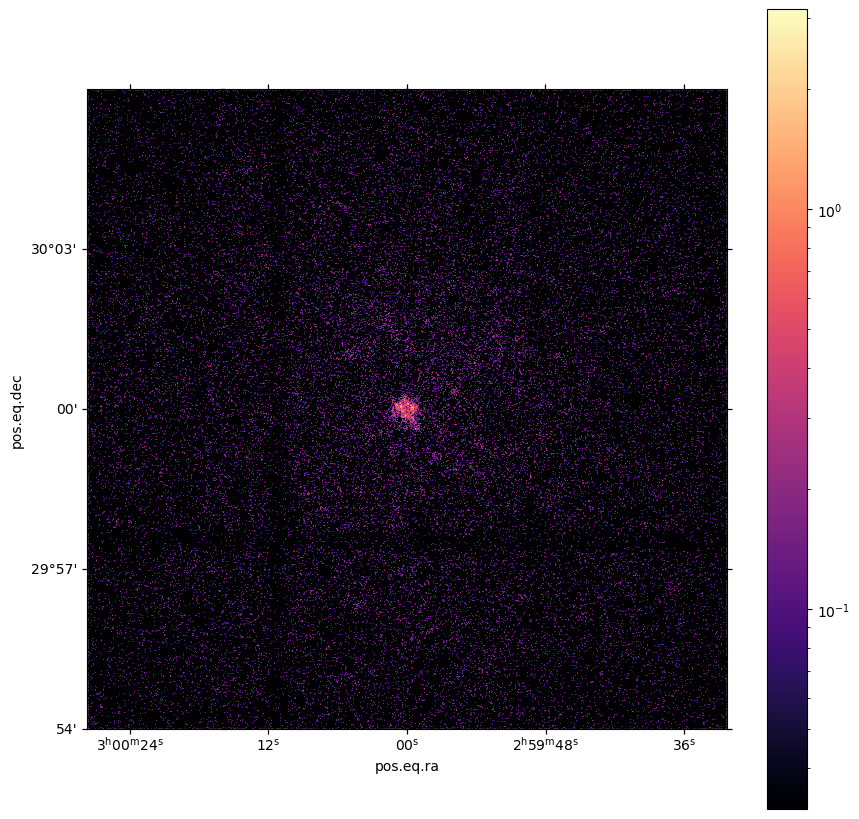

In [8]:
instrument = 'chandra_acisi_cy22'
instrument_exp = 200
instrument_sky_center_offset= 2
soxs.instrument_simulator(f"halo_{haloID}_simput.fits", f"halo_{haloID}_evt.fits", (instrument_exp, 'ks'), instrument, (45. + (instrument_sky_center_offset/60), 30 - (instrument_sky_center_offset/60)), 
                          overwrite=True, foreground=False, ptsrc_bkgnd=False)

soxs.write_image(f"halo_{haloID}_evt.fits", f"halo_{haloID}_img.fits", emin=0.5, emax=2.0, overwrite=True)

with fits.open(f"halo_{haloID}_img.fits") as f:
    w = wcs.WCS(header=f[0].header)
    fig, ax = soxs.plot_image(f"halo_{haloID}_img.fits", stretch='log', cmap='magma', vmin=10**-1.5, vmax=10**0.5, width=0.2, center=(45,30))

#soxs.write_spectrum(f"halo_{haloID}_evt.fits", f"halo_{haloID}_evt.pi", overwrite=True)
#fig, ax = soxs.plot_spectrum(f"halo_{haloID}_evt.pi", xmin=0.3, xmax=1.0, xscale="linear")

In [18]:
basePath = '/virgotng/universe/Simba/L100n1024FP/output'

halo = il.groupcat.loadSingle(basePath, 151, haloID=22)

In [19]:
filename = "../data/yt_halodata/mockhalo_SIMBA_22.hdf5"
ds = yt.load(filename)

yt : [INFO     ] 2024-05-21 16:13:33,334 Redshift is not set in Header. Assuming z=0.
yt : [INFO     ] 2024-05-21 16:13:33,344 Calculating time from 1.000e+00 to be 4.375e+17 seconds
yt : [INFO     ] 2024-05-21 16:13:33,432 Parameters: current_time              = 4.3748565942961114e+17 s
yt : [INFO     ] 2024-05-21 16:13:33,433 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2024-05-21 16:13:33,433 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2024-05-21 16:13:33,434 Parameters: domain_right_edge         = [100000. 100000. 100000.]
yt : [INFO     ] 2024-05-21 16:13:33,434 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-05-21 16:13:33,435 Parameters: current_redshift          = 0.0
yt : [INFO     ] 2024-05-21 16:13:33,435 Parameters: omega_lambda              = 0.7
yt : [INFO     ] 2024-05-21 16:13:33,436 Parameters: omega_matter              = 0.3
yt : [INFO     ] 2024-05-21 16:13:33,436 Parameters: omega_radiation           = 0

In [20]:
c = ds.arr([halo["GroupPos"][0], halo["GroupPos"][1], halo["GroupPos"][2]], "code_length")
r = halo['Group_R_Crit200']/0.68

In [23]:
def hot_gas(pfilter, data):
    pfilter1 = data[pfilter.filtered_type, "temperature"] > 10**5
    pfilter2 = data["PartType0", "StarFormationRate"] == 0.0
    pfilter3 = data["PartType0", "GFM_CoolingRate"] < 0.0
    return (pfilter1 & pfilter2) & pfilter3

yt.add_particle_filter("hot_gas", function=hot_gas, filtered_type='gas', requires=["temperature","density"])

In [24]:
ds.add_particle_filter("hot_gas")

True

yt : [INFO     ] 2024-05-21 16:24:07,712 xlim = 37660.714621 38869.558817
yt : [INFO     ] 2024-05-21 16:24:07,713 ylim = 69921.148214 71129.992411
yt : [INFO     ] 2024-05-21 16:24:07,716 xlim = 37660.714621 38869.558817
yt : [INFO     ] 2024-05-21 16:24:07,716 ylim = 69921.148214 71129.992411
yt : [INFO     ] 2024-05-21 16:24:07,717 Making a fixed resolution buffer of (('hot_gas', 'density')) 800 by 800



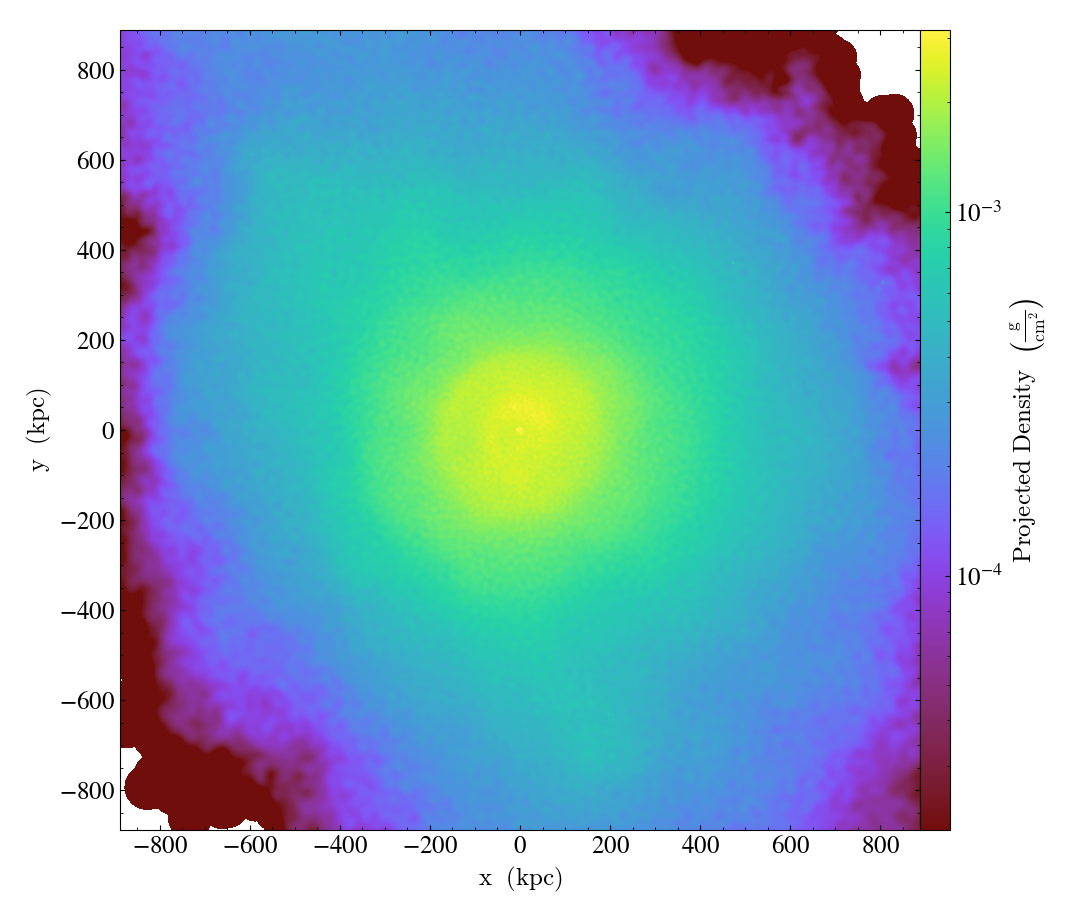

In [31]:
prj = yt.ProjectionPlot(ds, "z", ("hot_gas","density"), width=(2*r, "kpc"), center=c)
prj.set_zlim(("hot_gas","density"), 2.0e-5, 10**-2.5)

In [36]:
haloID = 11
events = pyxsim.EventList('../mockdata/EAGLE/%s'%f"halo_{haloID}_events.h5")
events.write_to_simput(f"halo_{haloID}", overwrite=True)


soxs : [INFO     ] 2024-05-21 16:28:22,087 Writing source 'halo_11' to halo_11_phlist.fits.


soxs : [INFO     ] 2024-05-22 13:34:55,416 Making observation of source in halo_22_evt.fits.
soxs : [INFO     ] 2024-05-22 13:34:56,441 Detecting events from source halo_22.
soxs : [INFO     ] 2024-05-22 13:34:56,442 Applying energy-dependent effective area from acisi_aimpt_cy22.arf.
soxs : [INFO     ] 2024-05-22 13:34:58,367 Pixeling events.
soxs : [INFO     ] 2024-05-22 13:34:58,378 Scattering events with a multi_image-based PSF.
soxs : [INFO     ] 2024-05-22 13:34:58,457 25632 events were detected from the source.
soxs : [INFO     ] 2024-05-22 13:34:58,461 Scattering energies with RMF acisi_aimpt_cy22.rmf.


Scattering energies :   0%|          | 0/25632 [00:00<?, ?it/s]

soxs : [INFO     ] 2024-05-22 13:34:58,600 Adding background events.
soxs : [INFO     ] 2024-05-22 13:34:58,647 Adding in instrumental background.
soxs : [INFO     ] 2024-05-22 13:34:58,694 Making 264983 events from the instrumental background.
soxs : [INFO     ] 2024-05-22 13:34:58,707 Writing events to file halo_22_evt.fits.
soxs : [INFO     ] 2024-05-22 13:34:58,767 Observation complete.


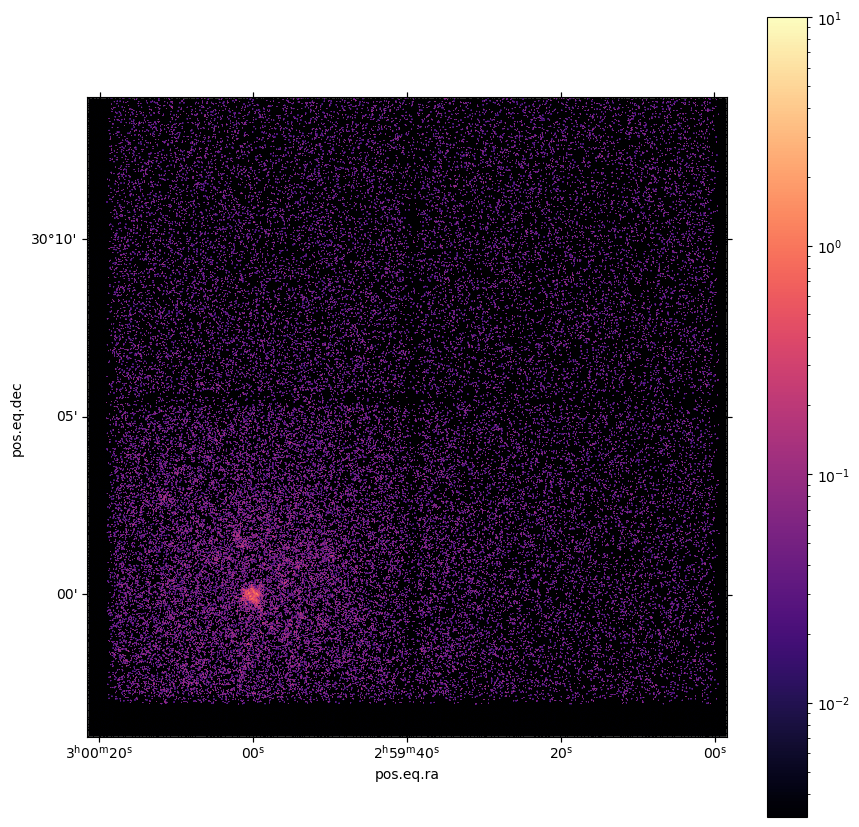

In [12]:
instrument = 'chandra_acisi_cy22'
instrument_exp = 200
instrument_sky_center_offset= -6
soxs.instrument_simulator(f"halo_{haloID}_simput.fits", f"halo_{haloID}_evt.fits", (instrument_exp, 'ks'), instrument, (45. + (instrument_sky_center_offset/60), 30 - (instrument_sky_center_offset/60)), 
                          overwrite=True, foreground=False, ptsrc_bkgnd=False)

soxs.write_image(f"halo_{haloID}_evt.fits", f"halo_{haloID}_img.fits", emin=0.5, emax=2.0, overwrite=True)

with fits.open(f"halo_{haloID}_img.fits") as f:
    w = wcs.WCS(header=f[0].header)
    fig, ax = soxs.plot_image(f"halo_{haloID}_img.fits", stretch='log', cmap='magma', vmin=10**-2.5, vmax=10**1, width=0.3, center=(45-5/60,30+5/60))


In [46]:
basePath2 = '/virgotng/universe/Eagle/Eagle100-1/output/'

halo2 = il.groupcat.loadSingle(basePath, 28, haloID=11)

In [47]:
c

yt : [INFO     ] 2024-05-21 16:34:40,399 Redshift is not set in Header. Assuming z=0.
yt : [INFO     ] 2024-05-21 16:34:40,409 Calculating time from 1.000e+00 to be 4.361e+17 seconds
yt : [INFO     ] 2024-05-21 16:34:40,495 Parameters: current_time              = 4.361431400043637e+17 s
yt : [INFO     ] 2024-05-21 16:34:40,496 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2024-05-21 16:34:40,497 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2024-05-21 16:34:40,498 Parameters: domain_right_edge         = [67770. 67770. 67770.]
yt : [INFO     ] 2024-05-21 16:34:40,499 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-05-21 16:34:40,499 Parameters: current_redshift          = 0.0
yt : [INFO     ] 2024-05-21 16:34:40,500 Parameters: omega_lambda              = 0.693
yt : [INFO     ] 2024-05-21 16:34:40,500 Parameters: omega_matter              = 0.307
yt : [INFO     ] 2024-05-21 16:34:40,501 Parameters: omega_radiation           = 0

In [50]:
c2 = ds.arr([halo2["GroupPos"][0], halo2["GroupPos"][1], halo2["GroupPos"][2]], "code_length")
r2 = halo2['Group_R_Crit200']/0.6777
ds2.add_particle_filter("hot_gas")

True

yt : [INFO     ] 2024-05-21 17:02:21,149 xlim = 7681.031882 8902.663430
yt : [INFO     ] 2024-05-21 17:02:21,150 ylim = 51793.438132 53015.069680
yt : [INFO     ] 2024-05-21 17:02:21,153 xlim = 7681.031882 8902.663430
yt : [INFO     ] 2024-05-21 17:02:21,154 ylim = 51793.438132 53015.069680
yt : [INFO     ] 2024-05-21 17:02:21,154 Making a fixed resolution buffer of (('hot_gas', 'density')) 800 by 800



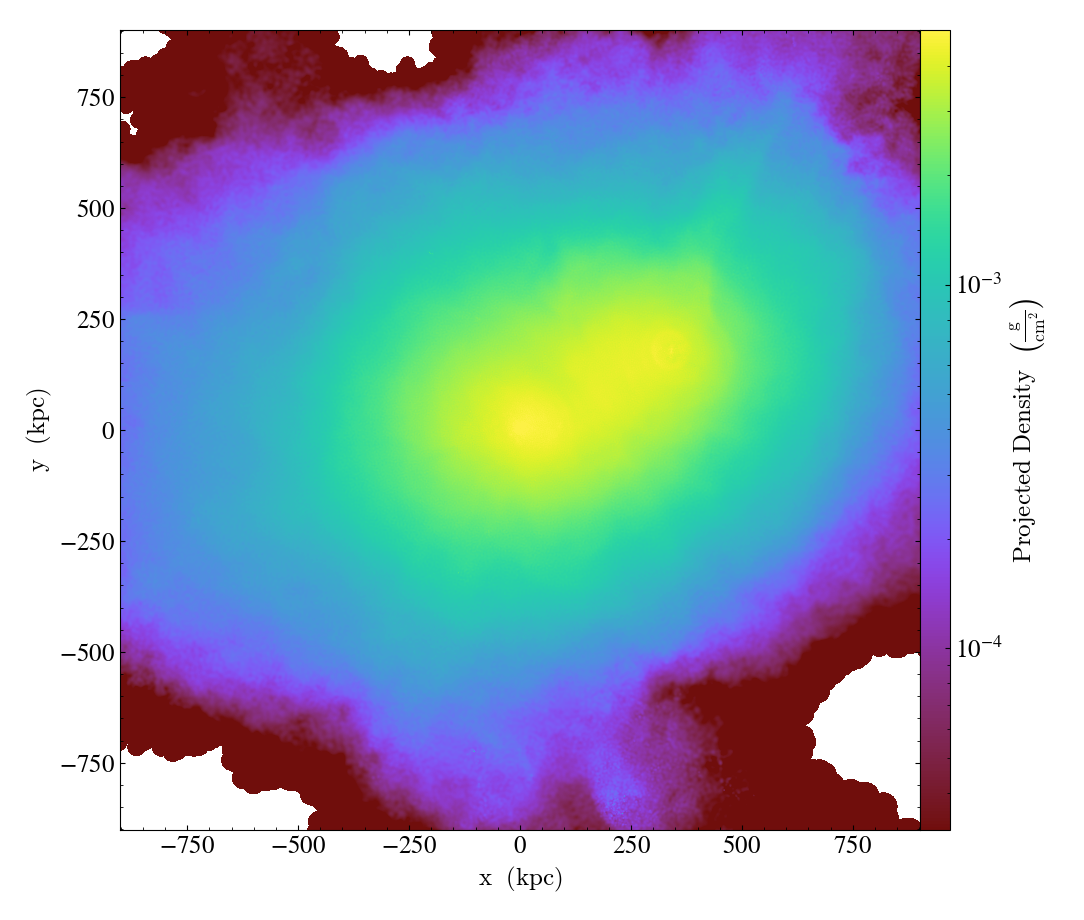

In [74]:
prj = yt.ProjectionPlot(ds2, "z", ("hot_gas","density"), center=c2, width=(2*r2, 'kpc'))
prj.set_zlim(("hot_gas","density"), 10**-4.5, 10**-2.3)